In [1]:
from pathlib import Path

from torchvision import transforms as tf
import yaml
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
from torch.utils.data import DataLoader, WeightedRandomSampler

import data.transforms as dtf
from data.comma_dataset import CommaDataset
from utils import logging, paths

/home/martin/miniconda3/envs/e2e/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'model': {'encoder': {'name': 'regnety_032', 'params': {'timm_feat_len': 1512, 'enc_feat_len': 256, 'dropout_prob': 0.4, 'in_channels': 6}}, 'decoder': {'name': 'FCDecoder', 'params': {'fc_size': 256, 'dropout_prob': 0.4}}}, 'training': {'num_steps': 100000, 'log_steps': 50, 'val_interval': 1000, 'num_log_imgs': 8, 'checkpoint_dir': '/home/martin/datasets/comma2k19/checkpoints', 'amp_backend': 'native', 'batch_size': 32, 'num_workers': 8}, 'dataset': {'dataset_file': 'full_trainval_set.json', 'future_steps': 30, 'past_steps': 1, 'channel_concat': True, 'weighing_factor': 0.5, 'num_bins': 100}, 'train_augs': {'img_augs': {'GaussianBlur': {'kernel_size': [3, 5], 'sigma': [0.01, 2]}, 'ColorJitter': {'brightness': 0.7, 'contrast': 0.6, 'saturation': 0.7, 'hue': 0.2}, 'Normalize': {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}}, 'full_augs': {'RandomHorizontalFlip': {'prob': 0.5}}}, 'val_augs': {'Normalize': {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}}, 'sc

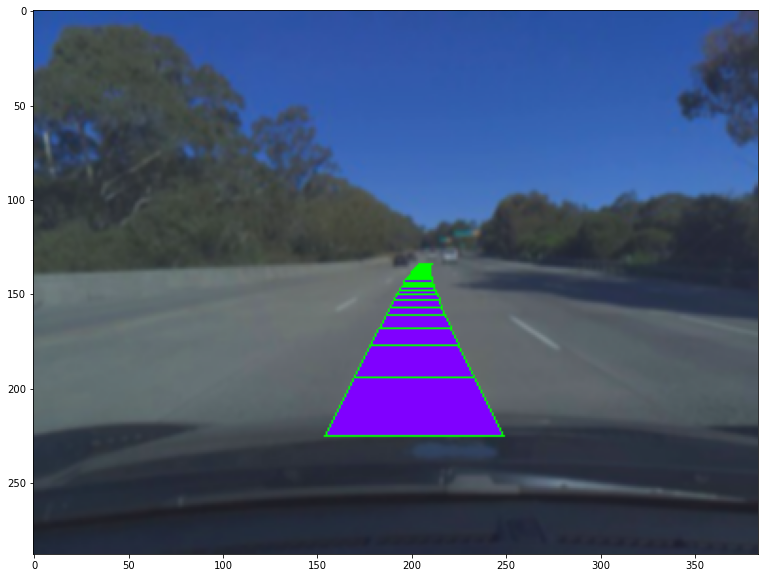

In [2]:
# Load config file to test dataset class and augs
cfg_name = "configs/regnet_2f_concat.yaml"
cfg_path = Path("/home/martin/projects/end-to-end-driving") / cfg_name
with cfg_path.open('r') as f:
    cfg = yaml.safe_load(f)
print(cfg)
cfg["dataset"]["dataset_file"] = "full_trainval_set_curv.json"

train_img_augs = tf.Compose([getattr(tf, name)(**kwargs) for name, kwargs in cfg['train_augs']['img_augs'].items()])
train_full_augs = tf.Compose([getattr(dtf, name)(**kwargs) for name, kwargs in cfg['train_augs']['full_augs'].items()])

train_set = CommaDataset(cfg, 'train', train_img_augs, train_full_augs)

print(f"trainset size: {len(train_set)}")
sample = train_set[0]
print("First training set sample:")
print(sample.keys())
print(sample['frames'].shape)
print(sample['frames'].dtype)
print(sample['label_path'].shape)
print(sample['label_path'].dtype)
print(sample['prev_path'].shape)
print(sample['prev_path'].dtype)

disp_img = logging.tensor_to_img(sample['frames'][0])
paths.draw_path(sample['label_path'].numpy(), disp_img)

plt.imshow(disp_img)
plt.show()

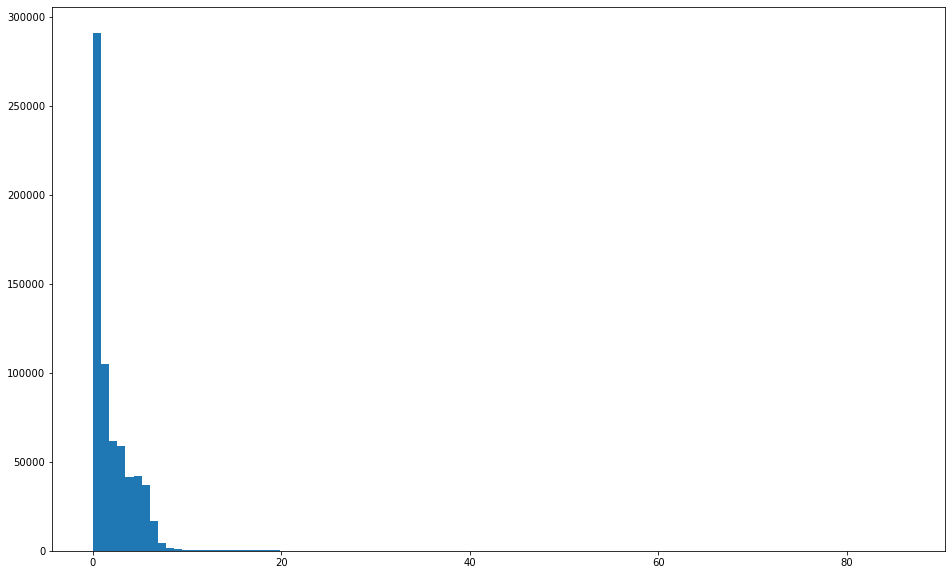

/tmp/ipykernel_3410038/1007311231.py:10: RuntimeWarning: divide by zero encountered in true_divide
  bin_weights = 1/counts**weighting_factor


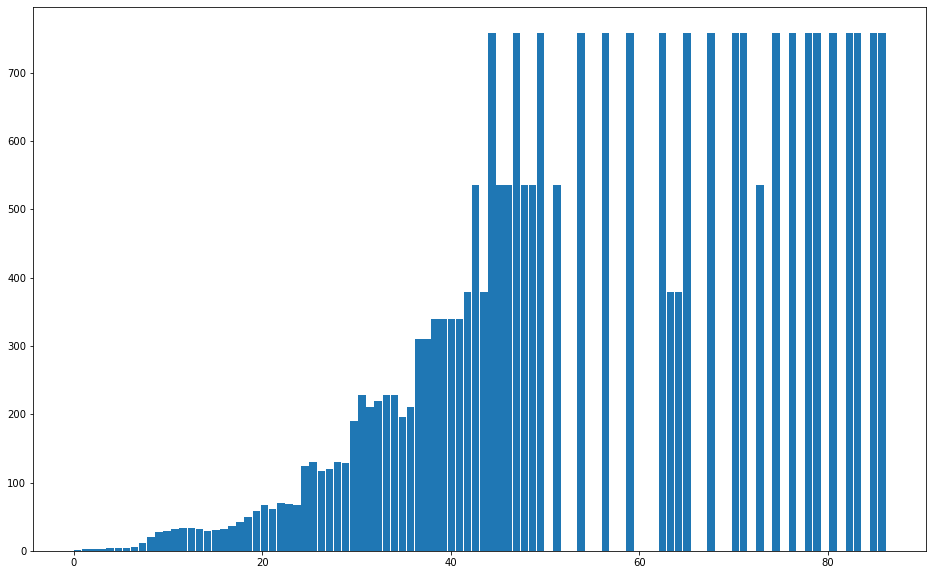

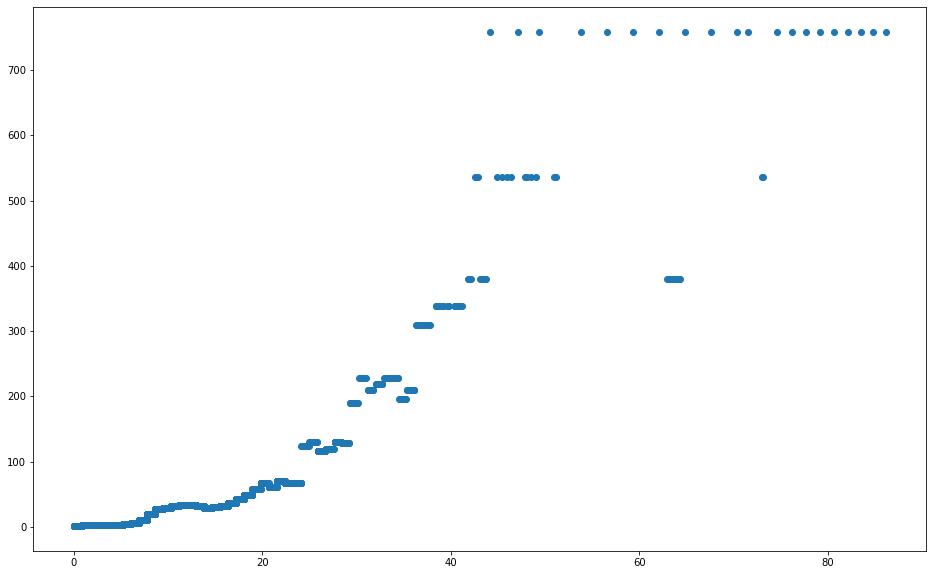

In [3]:
# Generate the sample weights for the weighted random sampler
num_bins = 100
curv = train_set.curvatures

plt.hist(curv, bins=num_bins)
plt.show()

counts, bins = np.histogram(curv, bins=num_bins, density=True)
weighting_factor = 0.5
bin_weights = 1/counts**weighting_factor

plt.bar(bins[:-1]+bins[1]/2, bin_weights)
plt.show()

sample_bin_idx = np.digitize(curv, bins, right=False) - 1

# Wrap 100 to 99
sample_bin_idx[sample_bin_idx == num_bins] = num_bins - 1

sample_weights = bin_weights[sample_bin_idx]

# This should be the same shape as the bin_weights histogram
plt.scatter(curv, sample_weights)
plt.show()

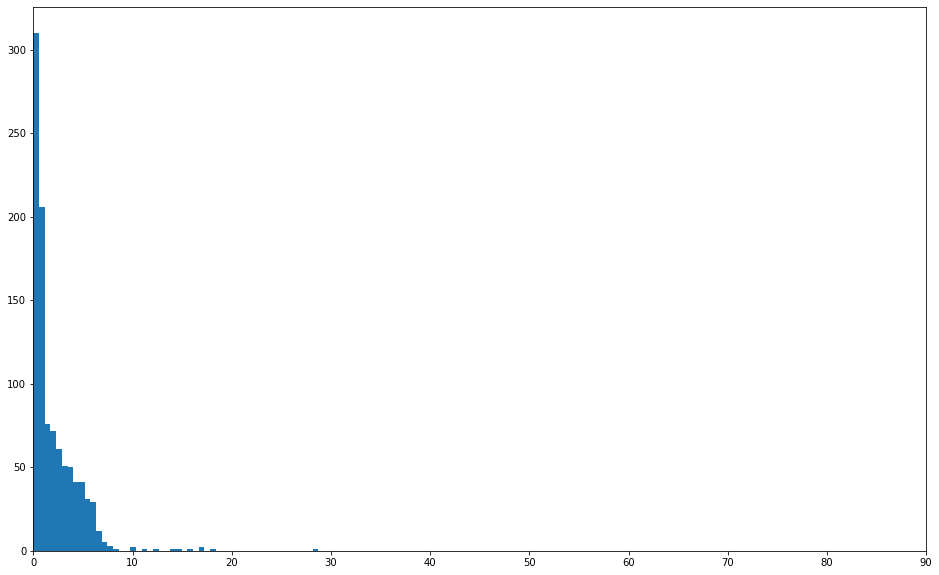

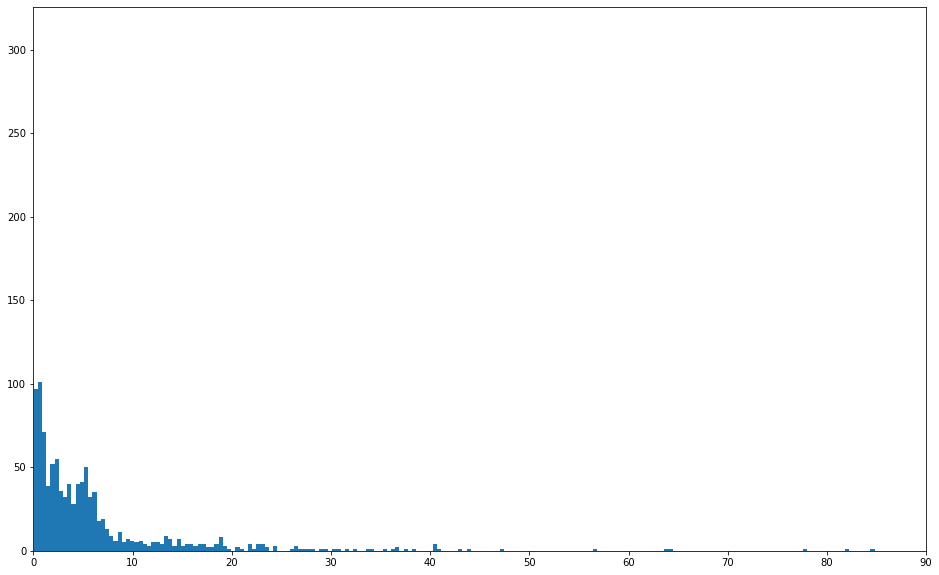

In [6]:
# Compare the weighted sampler to default
sampler = WeightedRandomSampler(sample_weights, 100000)
train_loader_weighted = DataLoader(
    train_set,
    batch_size=1,
    sampler=sampler,
    num_workers=1
)
train_loader = DataLoader(
    train_set,
    batch_size=1,
    num_workers=1,
    shuffle=True
)

num_it = 1000
default_sampler_curves = []
i = 1
for ex in train_loader:
    if i > num_it:
        break
    default_sampler_curves.append(ex['curv'].numpy()[0])
    i += 1
plt.hist(default_sampler_curves, bins=50)
plt.xlim(0, 90)
ylim = plt.gca().get_ylim()
plt.show()

weighted_sampler_curves = []
i = 1
for ex in train_loader_weighted:
    if i > num_it:
        break
    weighted_sampler_curves.append(ex['curv'].numpy()[0])
    i += 1
plt.hist(weighted_sampler_curves, bins=200)
plt.xlim(0, 90)
plt.ylim(ylim)
plt.show()